In [1]:
#this cell has what you will need to import

import numpy as np
import matplotlib.pyplot as plt

#I use these to loop over the directories
import os
from pathlib import Path

from astropy.io import fits #to read a fits file

#I use this package to convert from redshift to year
#Renyue implied doing this conversion is trivial
#but it is not. I suggest reading up on this
#package and then using it.
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.272)


In [2]:
def read_sun(director):
    
    
    masses=[] 
    sfrs=[]
    metals=[]
    ages=[]
    
    for filename in os.listdir(director):
        
        if filename.startswith('sun'):
            
            sfile=director+'/'+filename
                    
            hdul = fits.open(sfile)
            data=hdul[4].data                
            hdul.close()
                    
            #here I calculate the star formation rate as the total
            #mass of star particles less than a Myr old
            good_age=data['age']<1e6
            sfr = sum(data['mass'][good_age])/1e6
            
            masses.append(np.array(data['mass']))
            sfrs.append(sfr)
            metals.append(np.array(data['metallicity']))
            ages.append(np.array(data['age']))
                    

    masses=np.array(masses)
    sfrs=np.array(sfrs)
    metals=np.array(metals)
    ages=np.array(ages)
    

    return masses,sfrs,metals,ages

In [3]:
mass,sfr,metals,ages=read_sun('out01461')

In [4]:
#Now info for the starburst99 files
file14 = np.loadtxt('SED_Z0.014_starburst.txt')
minor14= np.delete(file14, 0, 0)
sed14 = np.delete(minor14,0,1)

file06 = np.loadtxt('SED_Z0.006_starburst.txt')
minor06= np.delete(file06, 0, 0)
sed06 = np.delete(minor06,0,1)

file02 = np.loadtxt('SED_Z0.002_starburst.txt')
minor02= np.delete(file02, 0, 0)
sed02 = np.delete(minor02,0,1)

file002 = np.loadtxt('SED_Z0.0002_starburst.txt')
minor002= np.delete(file002, 0, 0)
sed002 = np.delete(minor002,0,1)

wavelist = file14[0,1:]
agelist = minor14[:,0] #Wavelist and agelist are actually the reverse of what the txt files suggest
metlist = [0.0002, 0.002, 0.006, 0.014]


sedlist = np.asarray([sed002,sed02,sed06,sed14])
np.place(sedlist, sedlist==0, [1e-30])
sedlist = np.log10(sedlist)
#sedlist = np.swapaxes(sedlist,1,2)

In [5]:
#For testing
#print(len(agelist))
#print(agelist)

#print(ages[0][0])

In [6]:
#The first dimension is metallicity:
#data['zgrid']


In [7]:
#The next dimension is time:
#data['tgrid']

In [8]:
#And the final dimension is wavelength:
#data['wave']

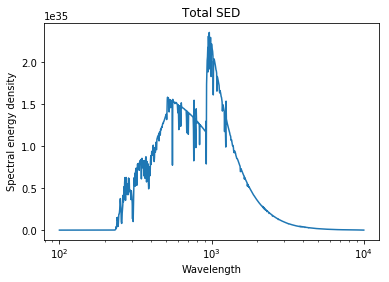

In [9]:
#Making the SED from the sun files – simple method, using nearest-neighbour interpolation

#gives the index of the closest array element to the value
#TODO: use a better interpolation method
def find_nearest(array, value):
    idx = np.argmin(np.abs(array - value))
    return idx

#Finding nearest-neighbour index for each sun's age and metallicity
totNNsed = np.zeros(len(wavelist)) #empty array to sum up the SED

for i in range(len(ages[0])): #for each particle
    ageindex = find_nearest(agelist, ages[0][i])#finding the closest values for the age and metallicity
    metindex = find_nearest(metlist, metals[0][i])
    massnormSED = sedlist[metindex, ageindex, :]+np.log10(mass[0][i]/1e6) #normalise by star particle mass
    unloggedSED = np.power(10, massnormSED)
    totNNsed = np.add(totNNsed, unloggedSED)

plt.plot(wavelist, totNNsed)
plt.title("Total SED")
plt.xlabel("Wavelength")
plt.ylabel("Spectral energy density")
plt.xscale('log')

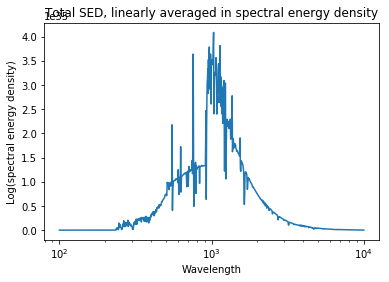

In [10]:
#Making the SED from the sun files using logarithmic interpolation

#gives the index of the closest array element to the value
#TODO: use a better interpolation method
def find_nearest(array, value):
    idx = np.argmin(np.abs(array - value))
    return idx

#gives the weighting of the star particle in time or metallicity using a logarithmic scaling
def logwtg(value, array):
    lindex = np.searchsorted(array, value, side='right')-1
    weight = np.log(value/array[lindex])/np.log(array[lindex+1]/array[lindex])
    return lindex, weight

#Finding nearest-neighbour index for each sun's age and metallicity
totNNsed = np.zeros(len(wavelist)) #empty array to sum up the SED

for i in range(len(ages[0])): #for each particle
    aindex, aweight = logwtg(ages[0][i], agelist)#finding the closest values for the age and metallicity
    zindex, zweight = logwtg(metals[0][i], metlist)
    wtSED = aweight*(zweight*sedlist[zindex+1,aindex+1,:]+(1-zweight)*sedlist[zindex,aindex+1,:])+(1-aweight)*((zweight*sedlist[zindex+1,aindex,:]+(1-zweight)*sedlist[zindex,aindex,:]))
    unloggedSED = np.power(10, wtSED)
    massnormSED = unloggedSED*mass[0][i]/1e6 #normalise by star particle mass
    totNNsed = np.add(totNNsed, massnormSED)

plt.plot(wavelist, totNNsed)
plt.title("Total SED, linearly averaged in spectral energy density")
plt.xlabel("Wavelength")
plt.ylabel("Log(spectral energy density)")
plt.xscale('log')

In [11]:
#test cell for making sure I don't screw up a 4-hour calculation
testarray = [-1, 0, 1, 2, 3]
print(np.power(np.e, testarray))

[ 0.36787944  1.          2.71828183  7.3890561  20.08553692]


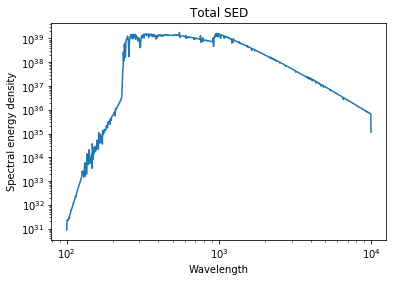

In [33]:
#Making the SED from the sun files using logarithmic interpolation

#gives the index of the closest array element to the value
def find_nearest(array, value):
    idx = np.argmin(np.abs(array - value))
    return idx

#gives the weighting of the star particle in time or metallicity using a logarithmic scaling
def logwtg(value, array):
    lindex = np.searchsorted(array, value, side='right')-1
    if lindex >= len(array)-1:
        weight = 0
    else:
        weight = np.log(value/array[lindex])/np.log(array[lindex+1]/array[lindex])
    return lindex, weight

#Finding nearest-neighbour index for each sun's age and metallicity
totlogwtsed = np.zeros(len(wavelist)) #empty array to sum up the SED

for j in range(len(ages)): #for each galaxy
    for i in range(len(ages[j])): #for each particle
        aindex, aweight = logwtg(ages[j][i], agelist)#finding the closest values for the age and metallicity
        zindex, zweight = logwtg(metals[j][i], metlist)
        if zindex == 3:
            wtSED = aweight*sedlist[zindex,aindex+1,:]+(1-aweight)*sedlist[zindex,aindex,:]
        else:
            wtSED = aweight*(zweight*sedlist[zindex+1,aindex+1,:]+(1-zweight)*sedlist[zindex,aindex+1,:])+(1-aweight)*((zweight*sedlist[zindex+1,aindex,:]+(1-zweight)*sedlist[zindex,aindex,:]))
        massnormSED = wtSED+np.log10(mass[j][i]/1e6) #normalise by star particle mass, in a logarithmic sense
        unloggedSED = np.power(10, massnormSED)
        totlogwtsed = np.add(totlogwtsed, unloggedSED)

plt.plot(wavelist, totlogwtsed)
plt.title("Total SED")
plt.xlabel("Wavelength")
plt.ylabel("Spectral energy density")
plt.xscale('log')
plt.yscale('log')

In [34]:
with open('strippedout.txt', 'w') as f:
    for i in range(len(totlogwtsed)):
        f.write(str(totlogwtsed[i])+'\n')

In [6]:
#Getting the peaks of star formation from the histogram
sfpeaks = np.asarray([0,65,100,140,210,260,340,400])*1e6 #times in megayears
sfpeaks0 = np.asarray([0,108,138,361])
#Function finding time since most recent peak in megayears
def peakage(age):
    lastpeak = sfpeaks[np.searchsorted(sfpeaks, age, side='right')-1]
    relage = age-lastpeak
    return relage, lastpeak

def peakage0(age):
    lastpeak = sfpeaks[np.searchsorted(sfpeaks0, age, side='right')-1]
    relage = age-lastpeak
    return relage, lastpeak

In [14]:
#giving the stripped SED for each relative age
totrelageSED = np.zeros((180, len(wavelist)))

def find_nearest(array, value):
    idx = np.argmin(np.abs(array - value))
    return idx

#gives the weighting of the star particle in time or metallicity using a logarithmic scaling
def logwtg(value, array):
    lindex = np.searchsorted(array, value, side='right')-1
    if lindex >= len(array)-1:
        weight = 0
    else:
        weight = np.log(value/array[lindex])/np.log(array[lindex+1]/array[lindex])
    return lindex, weight

for j in range(len(ages)): #for each galaxy
    print(j) #timing purposes
    for i in range(len(ages[j])): #for each particle
        aindex, aweight = logwtg(ages[j][i], agelist)#finding the closest values for the age and metallicity
        zindex, zweight = logwtg(metals[j][i], metlist)
        if zindex == 3:
            wtSED = aweight*sedlist[zindex,aindex+1,:]+(1-aweight)*sedlist[zindex,aindex,:]
        else:
            wtSED = aweight*(zweight*sedlist[zindex+1,aindex+1,:]+(1-zweight)*sedlist[zindex,aindex+1,:])+(1-aweight)*((zweight*sedlist[zindex+1,aindex,:]+(1-zweight)*sedlist[zindex,aindex,:]))
        massnormSED = wtSED+np.log10(mass[j][i]/1e6) #normalise by star particle mass, in a logarithmic sense
        unloggedSED = np.power(10, massnormSED)
        
        relage, lastpeak = peakage(ages[j][i])
        totrelageSED[int(relage/1e6)] = np.add(totrelageSED[int(relage/1e6)], unloggedSED)
    
with open('relagestrippedSED.txt', 'w') as f:
    for i in range(len(totrelageSED)):
        for j in range(len(totrelageSED[i])):
            f.write(str(totrelageSED[i][j])+'\n')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [7]:
#giving the stripped SED for each relative age IN GALAXY 0
totrelageSED = np.zeros((291, len(wavelist)))

def find_nearest(array, value):
    idx = np.argmin(np.abs(array - value))
    return idx

#gives the weighting of the star particle in time or metallicity using a logarithmic scaling
def logwtg(value, array):
    lindex = np.searchsorted(array, value, side='right')-1
    if lindex >= len(array)-1:
        weight = 0
    else:
        weight = np.log(value/array[lindex])/np.log(array[lindex+1]/array[lindex])
    return lindex, weight


for i in range(len(ages[0])): #for each particle
    aindex, aweight = logwtg(ages[0][i], agelist)#finding the closest values for the age and metallicity
    zindex, zweight = logwtg(metals[0][i], metlist)
    if zindex == 3:
        wtSED = aweight*sedlist[zindex,aindex+1,:]+(1-aweight)*sedlist[zindex,aindex,:]
    else:
        wtSED = aweight*(zweight*sedlist[zindex+1,aindex+1,:]+(1-zweight)*sedlist[zindex,aindex+1,:])+(1-aweight)*((zweight*sedlist[zindex+1,aindex,:]+(1-zweight)*sedlist[zindex,aindex,:]))
    massnormSED = wtSED+np.log10(mass[0][i]/1e6) #normalise by star particle mass, in a logarithmic sense
    unloggedSED = np.power(10, massnormSED)

    relage, lastpeak = peakage0(ages[0][i])
    totrelageSED[int(relage/1e6)] = np.add(totrelageSED[int(relage/1e6)], unloggedSED)
    
with open('gal0relagestrippedSED.txt', 'w') as f:
    for i in range(len(totrelageSED)):
        for j in range(len(totrelageSED[i])):
            f.write(str(totrelageSED[i][j])+'\n')